# GMM clustering

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib    #from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow.compat.v1 import set_random_seed    #from tensorflow import set_random_seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)    #tf.logging.set_verbosity(tf.logging.ERROR)

import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector    #from keras.layers import Input, Dropout, Dense, LSTM, TimdEistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

from tqdm import tqdm

# set random seed
seed(10)
set_random_seed(10)

In [2]:
df = pd.read_csv('C:/Users/MHyewon/Desktop/특수보안연구/2021_1학기_1_윤명근/04_hashed.csv',parse_dates=['Rdate'], dtype=object, index_col = ['Rdate'])

print(sorted(df.columns))
print(df.shape)

['Action', 'Proto', 'dst_country', 'dst_ip', 'dst_port', 'src_country', 'src_ip', 'src_port']
(5820310, 8)


In [3]:
df

,src_ip,dst_ip,Proto,src_port,dst_port,Action,src_country,dst_country
Rdate,,,,,,,,
2.021041e+13,154.58.159.102,103.177.12.42,6,52897,445,2,None,US
2.021041e+13,154.58.159.20,125.66.92.196,6,60579,445,2,None,DE
2.021041e+13,154.58.159.164,117.121.178.223,6,63831,445,2,None,US
2.021041e+13,154.58.159.165,205.34.95.97,6,55241,445,2,None,US
2.021041e+13,154.58.159.102,93.56.164.131,6,52898,445,2,None,US
...,...,...,...,...,...,...,...,...
2.021041e+13,12.150.252.150,102.116.52.100,6,64259,445,2,None,US
2.021041e+13,12.150.252.150,167.212.157.124,6,64261,445,2,None,CN
2.021041e+13,145.217.2.97,72.192.214.54,6,25646,23,2,ES,KR


In [4]:
src_ip_df = df[['src_ip','dst_ip']].copy()

src_ip_df = src_ip_df.reset_index()
del src_ip_df['Rdate']

In [5]:
print(src_ip_df.shape)
src_ip_df.head(5)

(5820310, 2)


,src_ip,dst_ip
0,154.58.159.102,103.177.12.42
1,154.58.159.20,125.66.92.196
2,154.58.159.164,117.121.178.223
3,154.58.159.165,205.34.95.97
4,154.58.159.102,93.56.164.131


In [6]:
src_ip_df.loc[:, 'oct1'] = src_ip_df['src_ip'].apply(lambda x: x.split(".")[0])
src_ip_df.loc[:, 'oct2'] = src_ip_df['src_ip'].apply(lambda x: x.split(".")[1])
src_ip_df.loc[:, 'oct3'] = src_ip_df['src_ip'].apply(lambda x: x.split(".")[2])
src_ip_df.loc[:, 'oct4'] = src_ip_df['src_ip'].apply(lambda x: x.split(".")[3])
src_ip_df.loc[:, 'oct5'] = src_ip_df['dst_ip'].apply(lambda x: x.split(".")[0])
src_ip_df.loc[:, 'oct6'] = src_ip_df['dst_ip'].apply(lambda x: x.split(".")[1])
src_ip_df.loc[:, 'oct7'] = src_ip_df['dst_ip'].apply(lambda x: x.split(".")[2])
src_ip_df.loc[:, 'oct8'] = src_ip_df['dst_ip'].apply(lambda x: x.split(".")[3])

src_ip_df = src_ip_df.reset_index()
print(src_ip_df)

           index          src_ip           dst_ip oct1 oct2 oct3 oct4 oct5  \
0              0  154.58.159.102    103.177.12.42  154   58  159  102  103   
1              1   154.58.159.20    125.66.92.196  154   58  159   20  125   
2              2  154.58.159.164  117.121.178.223  154   58  159  164  117   
3              3  154.58.159.165     205.34.95.97  154   58  159  165  205   
4              4  154.58.159.102    93.56.164.131  154   58  159  102   93   
...          ...             ...              ...  ...  ...  ...  ...  ...   
5820305  5820305  12.150.252.150   102.116.52.100   12  150  252  150  102   
5820306  5820306  12.150.252.150  167.212.157.124   12  150  252  150  167   
5820307  5820307    145.217.2.97    72.192.214.54  145  217    2   97   72   
5820308  5820308  154.58.159.164   185.151.199.60  154   58  159  164  185   
5820309  5820309   154.58.159.20  180.130.243.165  154   58  159   20  180   

        oct6 oct7 oct8  
0        177   12   42  
1         66 

In [7]:
# Drop duplicates
src_ip_df = src_ip_df.drop_duplicates(['src_ip'])
print(src_ip_df.shape)
print(src_ip_df)

(31032, 11)
           index          src_ip           dst_ip oct1 oct2 oct3 oct4 oct5  \
0              0  154.58.159.102    103.177.12.42  154   58  159  102  103   
1              1   154.58.159.20    125.66.92.196  154   58  159   20  125   
2              2  154.58.159.164  117.121.178.223  154   58  159  164  117   
3              3  154.58.159.165     205.34.95.97  154   58  159  165  205   
5              5   121.7.158.110    72.192.214.56  121    7  158  110   72   
...          ...             ...              ...  ...  ...  ...  ...  ...   
5819844  5819844   19.63.144.189    45.111.16.161   19   63  144  189   45   
5819953  5819953  218.49.146.227    45.111.16.186  218   49  146  227   45   
5820026  5820026   20.163.237.97    72.192.214.54   20  163  237   97   72   
5820203  5820203  128.164.118.48    72.192.214.62  128  164  118   48   72   
5820307  5820307    145.217.2.97    72.192.214.54  145  217    2   97   72   

        oct6 oct7 oct8  
0        177   12   42  
1

In [8]:
src_ip_df = src_ip_df.reset_index()
print(src_ip_df)

       level_0    index          src_ip           dst_ip oct1 oct2 oct3 oct4  \
0            0        0  154.58.159.102    103.177.12.42  154   58  159  102   
1            1        1   154.58.159.20    125.66.92.196  154   58  159   20   
2            2        2  154.58.159.164  117.121.178.223  154   58  159  164   
3            3        3  154.58.159.165     205.34.95.97  154   58  159  165   
4            5        5   121.7.158.110    72.192.214.56  121    7  158  110   
...        ...      ...             ...              ...  ...  ...  ...  ...   
31027  5819844  5819844   19.63.144.189    45.111.16.161   19   63  144  189   
31028  5819953  5819953  218.49.146.227    45.111.16.186  218   49  146  227   
31029  5820026  5820026   20.163.237.97    72.192.214.54   20  163  237   97   
31030  5820203  5820203  128.164.118.48    72.192.214.62  128  164  118   48   
31031  5820307  5820307    145.217.2.97    72.192.214.54  145  217    2   97   

      oct5 oct6 oct7 oct8  
0      103 

In [9]:
X_matrix_src = np.array(src_ip_df[['oct1','oct2','oct3','oct4','oct5', 'oct6', 'oct7', 'oct8']])
print(X_matrix_src.shape)
print(X_matrix_src[:5])
print()

(31032, 8)
[['154' '58' '159' '102' '103' '177' '12' '42']
 ['154' '58' '159' '20' '125' '66' '92' '196']
 ['154' '58' '159' '164' '117' '121' '178' '223']
 ['154' '58' '159' '165' '205' '34' '95' '97']
 ['121' '7' '158' '110' '72' '192' '214' '56']]



# PCA 적용

In [10]:
from sklearn.decomposition import PCA

#source
pcas = PCA(n_components=8)
pcas.fit(X_matrix_src)
print(pcas.explained_variance_ratio_)

[0.29787425 0.14656564 0.14270295 0.13765778 0.13662558 0.13578391
 0.00173648 0.0010534 ]


In [11]:
# 5개의 principal component를 통해 적어도 86% varinace 설명가능
#source
pca_src = PCA(n_components=5)
pcas = pca_src.fit_transform(X_matrix_src)

pcas1=[]
pcas2=[]
pcas3=[]
pcas4=[]
pcas5=[]

for i in pcas:
    pcas1.append(i[0])
    pcas2.append(i[1])
    pcas3.append(i[2])
    pcas4.append(i[3])
    pcas5.append(i[4])
    
print(pcas1[:5])
print(pcas2[:5])
print(len(pcas1))
print(pcas.shape)

[-75.22246721645486, -57.288909956459165, 38.35738363742973, -45.562613415111784, 109.60994263040229]
[-69.08343801822276, -91.58600354146141, -8.49745300572901, -27.29138233941665, -46.24374282025872]
31032
(31032, 5)


In [12]:
# 만든 matrix에 PCA를 적용하기 위해 4차원->3차원
src_ip_df['pca1'] = pcas1
src_ip_df['pca2'] = pcas2
src_ip_df['pca3'] = pcas3
src_ip_df['pca4'] = pcas4
src_ip_df['pca5'] = pcas5
print(src_ip_df[:2])

   level_0  index          src_ip         dst_ip oct1 oct2 oct3 oct4 oct5  \
0        0      0  154.58.159.102  103.177.12.42  154   58  159  102  103   
1        1      1   154.58.159.20  125.66.92.196  154   58  159   20  125   

  oct6 oct7 oct8       pca1       pca2       pca3       pca4       pca5  
0  177   12   42 -75.222467 -69.083438  92.940540  34.093628  23.654767  
1   66   92  196 -57.288910 -91.586004 -43.135059  24.246805 -84.219341  


## GMM clustering

In [13]:
from sklearn.mixture import BayesianGaussianMixture

In [14]:
# Check 7?10? clusters
bgms = BayesianGaussianMixture(n_components=3, n_init=30, random_state=100)
bgms.fit(X_matrix_src)
np.round(bgms.weights_, 2)

array([0.52, 0.47, 0.01])

In [15]:
pca_means = pca_src.transform(bgms.means_)
print(pca_means)

[[ 1.02063272e+02  1.18197095e+00 -5.24998796e+00 -4.31377445e-02
  -1.47480441e+00]
 [-1.13596633e+02 -7.71556201e-01  5.02337120e+00  8.09334682e-02
   1.44839123e+00]
 [ 2.62154307e+01 -2.27988992e+01  3.34711589e+01 -1.40921778e+00
   7.82071730e+00]]


In [16]:
means_df_s = pd.DataFrame(pca_means, columns=['pca1','pca2','pca3','pca4','pca5'])
means_df_s

,pca1,pca2,pca3,pca4,pca5
0,102.063272,1.181971,-5.249988,-0.043138,-1.474804
1,-113.596633,-0.771556,5.023371,0.080933,1.448391
2,26.215431,-22.798899,33.471159,-1.409218,7.820717


In [17]:
bgms.predict(X_matrix_src)

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

In [18]:
src_ip_df['kcluster'] = bgms.predict(X_matrix_src).tolist()
src_ip_df.tail(10)

,level_0,index,src_ip,dst_ip,oct1,oct2,oct3,oct4,oct5,oct6,oct7,oct8,pca1,pca2,pca3,pca4,pca5,kcluster
31022,5818734,5818734,215.160.61.232,45.111.16.190,215,160,61,232,45,111,16,190,-120.916394,46.722819,-87.028106,-42.923515,121.434004,1
31023,5818965,5818965,199.36.231.191,72.192.214.235,199,36,231,191,72,192,214,235,91.902013,-59.394530,-128.553149,134.665730,51.423208,0
31024,5818989,5818989,233.121.23.158,45.111.16.57,233,121,23,158,45,111,16,57,-108.082540,-11.209731,47.016498,-92.502454,115.251632,1
31025,5819511,5819511,253.226.224.19,45.111.16.248,253,226,224,19,45,111,16,248,-124.778551,-153.263319,-143.890711,-59.525242,-34.301377,1
31026,5819766,5819766,9.142.125.104,45.111.16.198,9,142,125,104,45,111,16,198,-119.376190,78.264843,-16.131202,28.035980,-101.143084,1
31027,5819844,5819844,19.63.144.189,45.111.16.161,19,63,144,189,45,111,16,161,-114.999411,89.727897,16.143317,109.839406,-24.821268,1
31028,5819953,5819953,218.49.146.227,45.111.16.186,218,49,146,227,45,111,16,186,-118.992076,-18.979125,-70.351140,74.130847,113.206187,1
31029,5820026,5820026,20.163.237.97,72.192.214.54,20,163,237,97,72,192,214,54,112.193303,0.041824,85.418191,61.918262,-65.841795,0
31030,5820203,5820203,128.164.118.48,72.192.214.62,128,164,118,48,72,192,214,62,108.091418,-37.041105,55.741564,-64.252923,-37.544718,0
31031,5820307,5820307,145.217.2.97,72.192.214.54,145,217,2,97,72,192,214,54,106.770079,43.006852,48.955263,-158.333785,17.251818,0


## Plot the clusters identified by GMM

In [19]:
dfs0 = src_ip_df[src_ip_df.kcluster==0]
dfs1 = src_ip_df[src_ip_df.kcluster==1]
dfs2 = src_ip_df[src_ip_df.kcluster==2]
#dfs3 = src_ip_df[src_ip_df.kcluster==3]

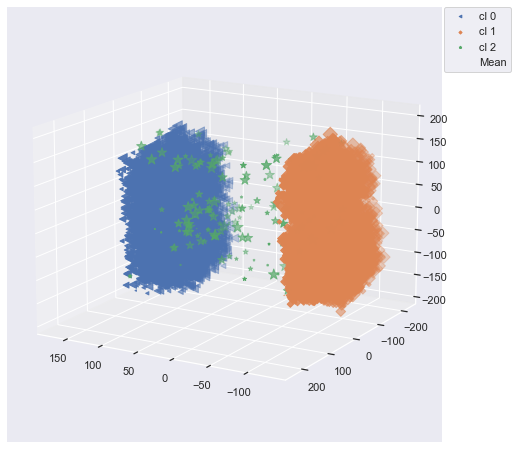

In [53]:
plt.rcParams["figure.figsize"] = (16,8)

ax=plt.figure().gca(projection='3d')
ax.scatter(dfs0['pca1'],dfs0['pca2'],dfs0['pca3'],s=dfs0['pca4'],marker="<",label="cl 0")
ax.scatter(dfs1['pca1'],dfs1['pca2'],dfs1['pca3'],s=dfs1['pca4'],marker="D",label="cl 1")
ax.scatter(dfs2['pca1'],dfs2['pca2'],dfs2['pca3'],s=dfs2['pca4'],marker="*",label="cl 2")

ax.scatter(means_df_s['pca1'],means_df_s['pca2'],means_df_s['pca3'],s=means_df_s['pca4'],marker="X",label="Mean", color='black')
ax.view_init(elev=15., azim=120)

plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.savefig('Clusters by GMM.png', dpi=300)
plt.show()

In [36]:
np.round(bgms.weights_, 3)

array([0.52 , 0.469, 0.011])

In [37]:
print(dfs0.oct1.value_counts())
print(dfs0.oct2.value_counts())
print(dfs0.oct3.value_counts())
#oct4, oct5
dfs0

101    213
22     167
168    164
231    120
147    110
      ... 
185     39
119     37
238     33
156     33
69      31
Name: oct1, Length: 256, dtype: int64
152    212
76     141
44     135
227    123
17     122
      ... 
20      41
48      40
186     40
10      39
8       38
Name: oct2, Length: 256, dtype: int64
137    219
149    163
234    137
119    134
74     111
      ... 
197     41
207     40
122     39
98      35
123     35
Name: oct3, Length: 256, dtype: int64


,level_0,index,src_ip,dst_ip,oct1,oct2,oct3,oct4,oct5,oct6,oct7,oct8,pca1,pca2,pca3,pca4,pca5,kcluster
4,5,5,121.7.158.110,72.192.214.56,121,7,158,110,72,192,214,56,109.609943,-46.243743,78.243248,78.542683,-1.735252,0
7,11,11,128.200.187.142,72.192.214.144,128,200,187,142,72,192,214,144,101.132014,-2.709947,-39.831525,1.837109,8.252277,0
8,31,31,129.20.11.57,72.192.214.0,129,20,11,57,72,192,214,0,112.448233,-13.586637,138.248896,-50.891514,-15.339442,0
11,40,40,212.252.12.184,72.192.214.179,212,252,12,184,72,192,214,179,93.629049,64.647993,-103.427887,-146.997174,86.398736,0
12,50,50,201.159.105.23,72.192.214.133,201,159,105,23,72,192,214,133,99.748244,-82.662373,-28.026121,-92.200325,-33.874503,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31018,5818398,5818398,108.163.133.71,72.192.214.129,108,163,133,71,72,192,214,129,101.568043,-9.946477,-3.415689,-31.234110,-52.386946,0
31023,5818965,5818965,199.36.231.191,72.192.214.235,199,36,231,191,72,192,214,235,91.902013,-59.394530,-128.553149,134.665730,51.423208,0
31029,5820026,5820026,20.163.237.97,72.192.214.54,20,163,237,97,72,192,214,54,112.193303,0.041824,85.418191,61.918262,-65.841795,0
31030,5820203,5820203,128.164.118.48,72.192.214.62,128,164,118,48,72,192,214,62,108.091418,-37.041105,55.741564,-64.252923,-37.544718,0


In [38]:
print(dfs1.oct1.value_counts())
print(dfs1.oct2.value_counts())
print(dfs1.oct3.value_counts())
dfs1

101    157
231    121
22     113
168    110
193    103
      ... 
179     35
217     34
146     34
65      34
35      33
Name: oct1, Length: 256, dtype: int64
152    171
44     111
227    106
134    103
192    102
      ... 
0       37
41      37
126     37
14      37
155     35
Name: oct2, Length: 256, dtype: int64
137    169
149    125
119    112
234    106
113     95
      ... 
81      37
221     37
52      36
157     33
154     27
Name: oct3, Length: 256, dtype: int64


,level_0,index,src_ip,dst_ip,oct1,oct2,oct3,oct4,oct5,oct6,oct7,oct8,pca1,pca2,pca3,pca4,pca5,kcluster
9,34,34,101.8.193.165,45.111.16.175,101,8,193,165,45,111,16,175,-116.271997,-7.894059,-12.734601,141.442124,-2.311903,1
13,58,58,187.245.26.74,45.111.16.145,187,245,26,74,45,111,16,145,-117.077904,5.177529,-29.382104,-169.242546,4.750849,1
14,61,61,138.18.147.184,45.111.16.186,138,18,147,184,45,111,16,186,-118.524706,4.032388,-36.072666,102.926901,32.310832,1
15,63,63,246.47.112.77,45.111.16.58,246,47,112,77,45,111,16,58,-106.891051,-119.329195,59.278625,-24.625202,56.142926,1
17,73,73,50.218.253.37,45.111.16.136,50,218,253,37,45,111,16,136,-110.866305,-42.655354,19.731646,19.200918,-109.025172,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31024,5818989,5818989,233.121.23.158,45.111.16.57,233,121,23,158,45,111,16,57,-108.082540,-11.209731,47.016498,-92.502454,115.251632,1
31025,5819511,5819511,253.226.224.19,45.111.16.248,253,226,224,19,45,111,16,248,-124.778551,-153.263319,-143.890711,-59.525242,-34.301377,1
31026,5819766,5819766,9.142.125.104,45.111.16.198,9,142,125,104,45,111,16,198,-119.376190,78.264843,-16.131202,28.035980,-101.143084,1
31027,5819844,5819844,19.63.144.189,45.111.16.161,19,63,144,189,45,111,16,161,-114.999411,89.727897,16.143317,109.839406,-24.821268,1


In [39]:
print(dfs2.oct1.value_counts())
print(dfs2.oct2.value_counts())
print(dfs2.oct3.value_counts())
dfs2

207    55
45     31
154    27
197    25
116    12
       ..
113     1
99      1
246     1
93      1
172     1
Name: oct1, Length: 100, dtype: int64
161    53
111    31
16     25
58     19
80     12
       ..
232     1
208     1
236     1
216     1
36      1
Name: oct2, Length: 107, dtype: int64
122    54
16     30
226    26
159    19
198    11
       ..
176     1
248     1
80      1
41      1
47      1
Name: oct3, Length: 108, dtype: int64


,level_0,index,src_ip,dst_ip,oct1,oct2,oct3,oct4,oct5,oct6,oct7,oct8,pca1,pca2,pca3,pca4,pca5,kcluster
0,0,0,154.58.159.102,103.177.12.42,154,58,159,102,103,177,12,42,-75.222467,-69.083438,92.940540,34.093628,23.654767,2
1,1,1,154.58.159.20,125.66.92.196,154,58,159,20,125,66,92,196,-57.288910,-91.586004,-43.135059,24.246805,-84.219341,2
2,2,2,154.58.159.164,117.121.178.223,154,58,159,164,117,121,178,223,38.357384,-8.497453,-95.172065,78.823691,12.759881,2
3,3,3,154.58.159.165,205.34.95.97,154,58,159,165,205,34,95,97,-45.562613,-27.291382,31.469611,63.369095,53.510224,2
5,7,7,12.150.252.150,134.142.64.254,12,150,252,150,134,142,64,254,-56.080788,48.950466,-87.313861,126.134821,-86.538655,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28987,5371827,5371827,235.196.220.83,97.128.191.138,235,196,220,83,97,128,191,138,59.656577,-122.487035,-56.442797,-29.955729,29.178531,2
29174,5426444,5426444,173.113.118.222,97.128.191.138,173,113,118,222,97,128,191,138,58.536958,28.442552,-37.111934,23.923043,95.734650,2
30148,5601408,5601408,101.50.145.99,97.128.191.138,101,50,145,99,97,128,191,138,59.165567,-15.036935,8.044653,57.326517,-42.479985,2
30251,5628631,5628631,116.116.19.108,97.128.191.138,116,116,19,108,97,128,191,138,56.712142,52.959325,-2.314990,-63.494174,-20.282306,2


## Find Anomalies/outliers

In [40]:
bgms.score_samples(X_matrix_src)

array([-49.01787484, -48.82638471, -47.86770688, ..., -26.6555747 ,
       -24.93259418, -26.7308307 ])

In [41]:
densities_s = bgms.score_samples(X_matrix_src)
dens_threshold_s = np.percentile(densities_s, 4)   ## density threshold: 4% (can customize)

print("Maximum Density : " + str(max(densities_s)))
print("Minimum Density : " + str(min(densities_s)))
print("Threshold Density : " + str(dens_threshold_s))

anomalies_s = X_matrix_src[densities_s < dens_threshold_s]

Maximum Density : -23.939581663241217
Minimum Density : -57.45535452761541
Threshold Density : -28.63528746942246


In [42]:
print(anomalies_s)
print(len(anomalies_s))

[['154' '58' '159' ... '177' '12' '42']
 ['154' '58' '159' ... '66' '92' '196']
 ['154' '58' '159' ... '121' '178' '223']
 ...
 ['245' '53' '207' ... '111' '16' '228']
 ['197' '246' '250' ... '111' '16' '3']
 ['253' '226' '224' ... '111' '16' '248']]
1242


In [43]:
print(len(dfs0))
print(len(dfs1))
print(len(dfs2))
print(len(anomalies_s))

16124
14566
342
1242


In [44]:
anomalies_df_s = src_ip_df[densities_s < dens_threshold_s]
anomalies_df_s

,level_0,index,src_ip,dst_ip,oct1,oct2,oct3,oct4,oct5,oct6,oct7,oct8,pca1,pca2,pca3,pca4,pca5,kcluster
0,0,0,154.58.159.102,103.177.12.42,154,58,159,102,103,177,12,42,-75.222467,-69.083438,92.940540,34.093628,23.654767,2
1,1,1,154.58.159.20,125.66.92.196,154,58,159,20,125,66,92,196,-57.288910,-91.586004,-43.135059,24.246805,-84.219341,2
2,2,2,154.58.159.164,117.121.178.223,154,58,159,164,117,121,178,223,38.357384,-8.497453,-95.172065,78.823691,12.759881,2
3,3,3,154.58.159.165,205.34.95.97,154,58,159,165,205,34,95,97,-45.562613,-27.291382,31.469611,63.369095,53.510224,2
5,7,7,12.150.252.150,134.142.64.254,12,150,252,150,134,142,64,254,-56.080788,48.950466,-87.313861,126.134821,-86.538655,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30936,5792515,5792515,24.8.47.191,45.111.16.248,24,8,47,191,45,111,16,248,-126.075699,137.590463,-53.687039,91.408000,-45.698362,1
30938,5792927,5792927,254.1.116.254,72.192.214.166,254,1,116,254,72,192,214,166,96.688101,-20.370337,-78.787376,79.281430,153.156930,0
30942,5793452,5793452,245.53.207.245,45.111.16.228,245,53,207,245,45,111,16,228,-122.375488,-50.194723,-122.850021,113.716290,128.680401,1
31014,5818136,5818136,197.246.250.79,45.111.16.3,197,246,250,79,45,111,16,3,-97.921887,-127.550788,88.781875,-47.143419,49.863672,1


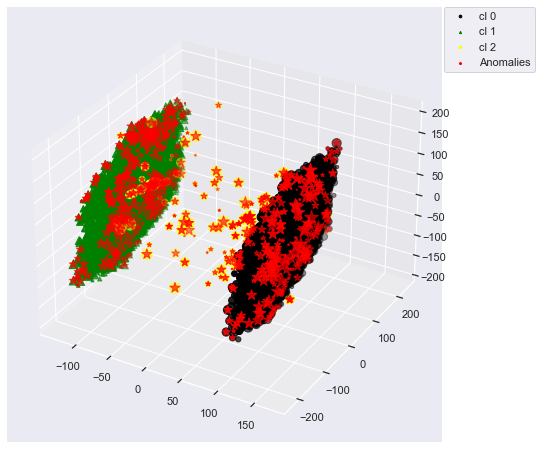

In [54]:
plt.rcParams["figure.figsize"] = (16,8)

ax=plt.figure().gca(projection='3d')
ax.scatter(dfs0['pca1'],dfs0['pca2'],dfs0['pca3'],s=dfs0['pca4'],label="cl 0", color='black')
ax.scatter(dfs1['pca1'],dfs1['pca2'],dfs1['pca3'],s=dfs1['pca4'],marker="^",label="cl 1", color='green')
ax.scatter(dfs2['pca1'],dfs2['pca2'],dfs2['pca3'],s=dfs2['pca4'],marker="o",label="cl 2", color='yellow')
ax.scatter(anomalies_df_s['pca1'],anomalies_df_s['pca2'],anomalies_df_s['pca3'],s=anomalies_df_s['pca4'],marker="*",label="Anomalies", color='red')

plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.savefig('Anomalies.png', dpi=300)
plt.show()

In [55]:
list(anomalies_df_s.src_ip)

filepath = 'C:/Users/MHyewon/Desktop/특수보안연구/abnormal_src_ip_list.txt'
with open(filepath,'w+') as lf:
    lf.write('\n'.join(list(anomalies_df_s.src_ip)))